# S2: AirBnb NYC 2024 Listings
by: Tam Trinh           
March 24, 2025         

<a id="0"></a> <br>
## Table of Contents  

- [Sprint Goals](#6)
- [Introduction](#1)
- [Set-up and Dataset Overview](#7)
- [Part 1: EDA](#2)
- [Part 2: Preprocessing](#3)   
- [Part 3: Modeling](#4) 
- [Stylized Visualizations](#8) 
- [Conclusion](#5)

<a id="7"></a>
## Set-up and Dataset Overview

In [54]:
# imports for functionality and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# optional imports
import warnings
import pickle

# imports for preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

In [55]:
# ignore warnings
from warnings import filterwarnings
warnings.filterwarnings('ignore')

In [56]:
# load cleaned dataset
cleaned_airbnb = pd.read_csv("../data/cleaned_airbnb.csv")

In [57]:
cleaned_limit500 = cleaned_airbnb[cleaned_airbnb["price"] <= 500]

In [58]:
cleaned_limit1000 = cleaned_airbnb[cleaned_airbnb["price"] <= 1000]

__________________

<a id="4"></a>
## Part 3: Modeling

### Train/test split

In [59]:
# split the data into train and test sets
X = cleaned_limit500.loc[:, cleaned_airbnb.columns != "price"]
y = cleaned_limit500["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [60]:
# optional:

# # sample for quicker test runs
# sample_airbnb = cleaned_airbnb.sample(n=5000, random_state=1)

# # split the data into train and test sets
# X = sample_airbnb.loc[:, sample_airbnb.columns != "price"]
# y = sample_airbnb["price"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Linear Regression Modeling

#### Fit initial linear regression model

In [61]:
# initialize linear regression model
linreg = LinearRegression()

# fit logistic regression model to xtrain
linreg.fit(X_train, y_train)

# get scores for train and test
print(f"Train score: {linreg.score(X_train, y_train)}")
print(f"Test score: {linreg.score(X_test, y_test)}")

Train score: 0.4164109391444635
Test score: 0.3862578018771333


An initial testing of a linear regression model is performed to poor results. Surprisingly, the test score performed better than the train score.

#### Feature Coefficients

In [62]:
linreg_coef = pd.Series(linreg.coef_, index=X_test.columns)

In [63]:
linreg_coef.sort_values(ascending=False)

roomtype_Entire home/apt           30.330792
roomtype_Hotel room                27.704304
bedrooms                           25.789968
ratings_5                          22.455410
ratings_4.8                        20.073054
neighgroup_Queens                  18.331859
latitude                           16.148882
neighgroup_Manhattan               14.843848
license_Has License                13.724171
license_Exempt                     13.418323
baths                              13.384154
beds                               12.657458
ratings_No rating                   8.003885
neighgroup_Bronx                    6.514783
ratings_4.6                         3.941798
neighgroup_Brooklyn                 3.363830
reviews_per_month                   0.961540
neighborhood_avgprice               0.254980
availability_365                    0.028248
minimum_nights                     -0.009709
calculated_host_listings_count     -0.020297
number_of_reviews                  -0.036622
number_of_

#### Set-up pipeline and gridsearch

In [64]:
estimators = [("scaler", StandardScaler()),
              ("pca", PCA()),
              ('linreg', LinearRegression())]

cachedir = mkdtemp()
pipe = Pipeline(estimators, memory=cachedir)

params = {"scaler": [StandardScaler(), None], 
          "pca__n_components": [5, 10, 20,]
}

grid_search = GridSearchCV(pipe, param_grid=params, cv=5)


A pipeline and gridsearch structure is built to run the model through. The StandardScaler, PCA, and Linear Regression are used. 

#### Fit the gridsearch best fit model

In [65]:
linreg_best = grid_search.fit(X_train, y_train)

In [66]:
linreg_best.best_estimator_


Pipeline(memory='/var/folders/s2/vdwvjj2j24d4tg5yz10ycr080000gn/T/tmp8n3yzy_j',
         steps=[('scaler', None), ('pca', PCA(n_components=20)),
                ('linreg', LinearRegression())])

In [67]:
print(f"The best fit scaler is: {linreg_best.best_estimator_[0]}")
print(f"The best fit number of PCA components is: {linreg_best.best_estimator_[1]}")
print(f"The best fit model is: {linreg_best.best_estimator_[2]}")

The best fit scaler is: None
The best fit number of PCA components is: PCA(n_components=20)
The best fit model is: LinearRegression()


The gridsearch parameters improved the test score from 0.12 to 0.13, being able to explain 13% of the price information. For the gridsearch the StandardScaler performed better than no scaler, and PCA 10 components performed the best. Since the lowest number of PCA performed the best, this can indicate that the features might not be helping with the price prediction. Perhaps they are not linearly correlated with price. Furthur analysis can look into non-linear relationship modeling. 

In [68]:
# linreg_best train and test scores
print(f"Train score: {linreg_best.score(X_train, y_train)}")
print(f"Test score: {linreg_best.score(X_test, y_test)}")

Train score: 0.40423060791755516
Test score: 0.37443973415133924


In [69]:
# make array of y_pred
y_pred = linreg_best.predict(X_test)

In [70]:
# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 72.18248892105767


In [71]:
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

print("MAE:", mae)

MAE: 51.79853408510059


In [72]:
# compare y_pred to y_true

# add to df
y_truevspred = pd.DataFrame({"True_y": y_test, "Pred_y": y_pred})

# display
y_truevspred

,True_y,Pred_y
16115,357.0,189.387640
1289,85.0,132.338482
2465,190.0,194.921987
9515,286.0,297.640414
12319,180.0,148.020145
...,...,...
13030,150.0,183.723788
15081,229.0,151.007193
9385,100.0,135.687127
3356,214.0,169.025282


#### Plots of predicted vs actual

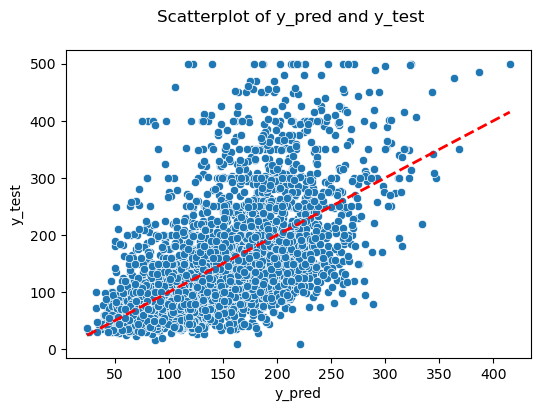

In [73]:
# scatterplot

plt.figure(figsize=(6,4))
ax = sns.scatterplot(x=y_pred, y=y_test)
plt.suptitle("Scatterplot of y_pred and y_test")
plt.xlabel("y_pred")
plt.ylabel("y_test")

x_vals = np.linspace(y_pred.min(), y_pred.max(), 100)
ax.plot(x_vals, x_vals, color='red', linestyle='--', linewidth=2) 

plt.show()


In this scatterplot of the predicted price values versus the actual price values, the predicted was capped at about 3,000, meanwhile the actual value went as high as 10,000. In linear regression, this punishes the model severely as the large values of error are squared, giving more weight to outliers. In the case of this dataset, the outliers are already large, and this magnifies the effect of the outliers, further punishing the model. Further analysis could look into handling the outliers.

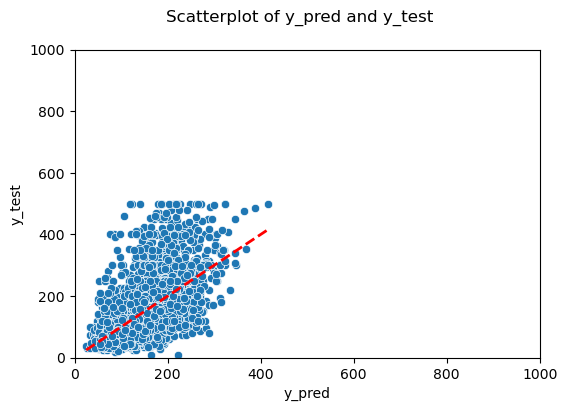

In [74]:
# scatterplot

plt.figure(figsize=(6,4))
ax = sns.scatterplot(x=y_pred, y=y_test)
plt.suptitle("Scatterplot of y_pred and y_test")
plt.xlabel("y_pred")
plt.ylabel("y_test")

x_vals = np.linspace(y_pred.min(), y_pred.max(), 100)
ax.plot(x_vals, x_vals, color='red', linestyle='--', linewidth=2) 

plt.xlim(0, 1000)
plt.ylim(0, 1000)

plt.show()


When zooming into the values less than 1,000, the model seemed to performed much better. With similar amounts above the line, showing when actual price is higher than predicted price, and a similar amount under the line, showing when predicted price is higher than actual price.

#### Pickle and save model

In [75]:
pickle.dump(linreg_best, open("../models/linreg_model.pkl","wb"))

In [76]:
# # to load model (optional)
# linreg_model = pickle.load(open("../models/linreg_model.pkl","rb"))

***

### XGBoost Modeling

In [77]:
# initialize xgboost model
xgb_model = XGBRegressor()

# fit logistic regression model to xtrain
xgb_model.fit(X_train, y_train)

# get scores for train and test
print(f"Train score: {xgb_model.score(X_train, y_train)}")
print(f"Test score: {xgb_model.score(X_test, y_test)}")

Train score: 0.7979406803824365
Test score: 0.5248005633205888


An initial testing of a linear regression model is performed to poor results. Surprisingly, the test score performed better than the train score.

#### Feature Importance

In [78]:
importances = xgb_model.feature_importances_

feature_importances = pd.Series(importances, index=X_test.columns)

feature_importances.sort_values(ascending=False)

roomtype_Entire home/apt          0.293657
license_No License                0.248750
baths                             0.095256
bedrooms                          0.041803
roomtype_Hotel room               0.025196
license_Exempt                    0.022942
beds                              0.022604
neighborhood_avgprice             0.019371
calculated_host_listings_count    0.017419
ratings_No rating                 0.016141
ratings_4.8                       0.014345
neighgroup_Manhattan              0.013910
minimum_nights                    0.013362
ratings_5                         0.012782
longitude                         0.010837
reviews_per_month                 0.009672
availability_365                  0.009060
ratings_3.0                       0.008836
number_of_reviews_ltm             0.007052
latitude                          0.006933
ratings_4.2                       0.006909
neighgroup_Queens                 0.006892
neighgroup_Brooklyn               0.006827
month      

In [79]:
# alternative booster importance
booster = xgb_model.get_booster()
importance_dict = booster.get_score(importance_type='cover')  

# display
importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Importance
ratings_3.0,15870.599609
license_No License,6737.636230
roomtype_Shared room,6666.000000
ratings_less3,6263.500000
ratings_New,5838.399902
license_Has License,4449.643066
last_review_year,3768.469971
ratings_4.8,3704.600098
ratings_4.0,2962.866699
ratings_4.2,2381.933350


#### Set-up pipeline and gridsearch

In [80]:
estimators = [("scaler", StandardScaler()),
              ("pca", PCA()),
              ('xgb', XGBRegressor())]

cachedir = mkdtemp()
pipe = Pipeline(estimators, memory=cachedir)

params = {"scaler": [StandardScaler(), None], 
          "pca__n_components": [5, 10, 20,]
}

grid_search = GridSearchCV(pipe, param_grid=params, cv=5)


A pipeline and gridsearch structure is built to run the model through. The StandardScaler, PCA, and Linear Regression are used. 

#### Fit the gridsearch best fit model

In [81]:
xgb_best = grid_search.fit(X_train, y_train)

In [82]:
xgb_best.best_estimator_

Pipeline(memory='/var/folders/s2/vdwvjj2j24d4tg5yz10ycr080000gn/T/tmp8a9ylobk',
         steps=[('scaler', None), ('pca', PCA(n_components=20)),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None,...e,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [83]:
print(f"The best fit scaler is: {xgb_best.best_estimator_[0]}")
print(f"The best fit number of PCA components is: {xgb_best.best_estimator_[1]}")
print(f"The best fit model is: {xgb_best.best_estimator_[2]}")

The best fit scaler is: None
The best fit number of PCA components is: PCA(n_components=20)
The best fit model is: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


The gridsearch parameters improved the test score from 0.12 to 0.13, being able to explain 13% of the price information. For the gridsearch the StandardScaler performed better than no scaler, and PCA 10 components performed the best. Since the lowest number of PCA performed the best, this can indicate that the features might not be helping with the price prediction. Perhaps they are not linearly correlated with price. Furthur analysis can look into non-linear relationship modeling. 

In [84]:
# linreg_best train and test scores
print(f"Train score: {xgb_best.score(X_train, y_train)}")
print(f"Test score: {xgb_best.score(X_test, y_test)}")

Train score: 0.8161786494978427
Test score: 0.4365508465710929


In [85]:
# make array of y_pred
y_pred = xgb_best.predict(X_test)

In [86]:
# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 68.50537380848395


In [87]:
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

print("MAE:", mae)

MAE: 47.70032455727153


In [88]:
# compare y_pred to y_true

# add to df
y_truevspred = pd.DataFrame({"True_y": y_test, "Pred_y": y_pred})

# display
y_truevspred

,True_y,Pred_y
16115,357.0,174.377472
1289,85.0,95.883728
2465,190.0,214.942947
9515,286.0,301.650085
12319,180.0,176.558411
...,...,...
13030,150.0,170.870850
15081,229.0,152.403931
9385,100.0,116.372253
3356,214.0,146.458832


#### Plots of predicted vs actual

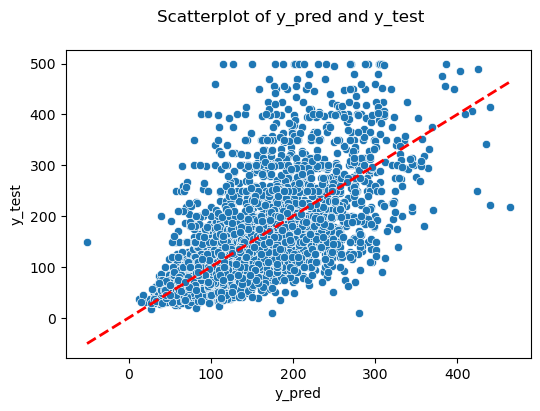

In [89]:
# scatterplot

plt.figure(figsize=(6,4))
ax = sns.scatterplot(x=y_pred, y=y_test)
plt.suptitle("Scatterplot of y_pred and y_test")
plt.xlabel("y_pred")
plt.ylabel("y_test")

x_vals = np.linspace(y_pred.min(), y_pred.max(), 100)
ax.plot(x_vals, x_vals, color='red', linestyle='--', linewidth=2) 

plt.show()


In this scatterplot of the predicted price values versus the actual price values, the predicted was capped at about 3,000, meanwhile the actual value went as high as 10,000. In linear regression, this punishes the model severely as the large values of error are squared, giving more weight to outliers. In the case of this dataset, the outliers are already large, and this magnifies the effect of the outliers, further punishing the model. Further analysis could look into handling the outliers.

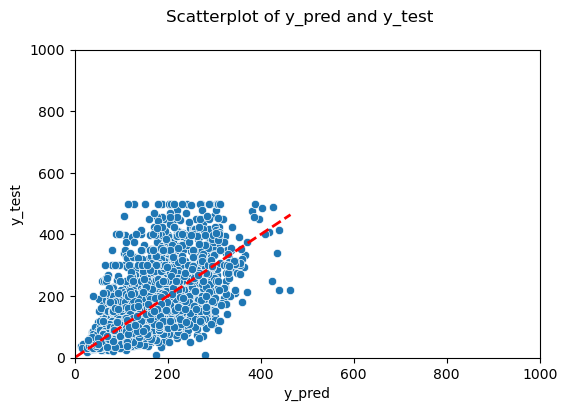

In [90]:
# scatterplot

plt.figure(figsize=(6,4))
ax = sns.scatterplot(x=y_pred, y=y_test)
plt.suptitle("Scatterplot of y_pred and y_test")
plt.xlabel("y_pred")
plt.ylabel("y_test")

x_vals = np.linspace(y_pred.min(), y_pred.max(), 100)
ax.plot(x_vals, x_vals, color='red', linestyle='--', linewidth=2) 

plt.xlim(0, 1000)
plt.ylim(0, 1000)

plt.show()


When zooming into the values less than 1,000, the model seemed to performed much better. With similar amounts above the line, showing when actual price is higher than predicted price, and a similar amount under the line, showing when predicted price is higher than actual price.

#### Pickle and save model

In [91]:
pickle.dump(xgb_best, open("../models/xgb_model.pkl","wb"))

_________________________________

### Random Forest Modeling

In [92]:
# initialize rforest
rforest_model = RandomForestRegressor()

# fit logistic regression model to xtrain
rforest_model.fit(X_train, y_train)

# get scores for train and test
print(f"Train score: {rforest_model.score(X_train, y_train)}")
print(f"Test score: {rforest_model.score(X_test, y_test)}")

Train score: 0.9361203517131793
Test score: 0.5166320698074791


An initial testing of a linear regression model is performed to poor results. Surprisingly, the test score performed better than the train score.

#### Feature Importance

In [93]:
importances = rforest_model.feature_importances_

feature_importances = pd.Series(importances, index=X_test.columns)

feature_importances.sort_values(ascending=False)

roomtype_Entire home/apt          0.174629
longitude                         0.090820
baths                             0.082908
latitude                          0.081089
neighborhood_avgprice             0.074148
reviews_per_month                 0.065475
bedrooms                          0.060658
availability_365                  0.057860
calculated_host_listings_count    0.053356
number_of_reviews                 0.042452
beds                              0.033402
number_of_reviews_ltm             0.028835
license_No License                0.026150
minimum_nights                    0.018815
roomtype_Private room             0.017763
month                             0.016145
last_review_month                 0.016077
last_review_year                  0.011189
ratings_5                         0.008083
ratings_4.8                       0.006468
ratings_4.6                       0.005759
ratings_4.4                       0.004006
license_Exempt                    0.003928
neighgroup_

In [94]:
# Compute permutation importance
result = permutation_importance(rforest_model, X_test, y_test, n_repeats=10, random_state=0)

# Convert to Series for plotting
perm_importances = pd.Series(result.importances_mean, index=X.columns)
perm_importances

latitude                          4.761770e-02
longitude                         1.017462e-01
minimum_nights                    1.744200e-02
number_of_reviews                 1.042748e-02
reviews_per_month                 3.399922e-02
calculated_host_listings_count    9.320358e-02
availability_365                  3.258727e-02
number_of_reviews_ltm             1.150017e-02
bedrooms                          1.041782e-01
beds                              4.917367e-02
baths                             7.961522e-02
month                             8.397811e-06
neighborhood_avgprice             8.762492e-02
last_review_month                -2.206594e-04
last_review_year                  2.884077e-03
neighgroup_Bronx                  1.479292e-04
neighgroup_Brooklyn               4.068807e-04
neighgroup_Manhattan              3.556784e-03
neighgroup_Queens                -2.387325e-04
neighgroup_Staten Island          1.070151e-04
roomtype_Entire home/apt          2.456139e-01
roomtype_Hote

#### Set-up pipeline and gridsearch

In [95]:
estimators = [("scaler", StandardScaler()),
              ("pca", PCA()),
              ('rf', RandomForestRegressor())]

cachedir = mkdtemp()
pipe = Pipeline(estimators, memory=cachedir)

params = {"scaler": [StandardScaler(), None], 
          "pca__n_components": [5, 10, 20,]
}

grid_search = GridSearchCV(pipe, param_grid=params, cv=5)


A pipeline and gridsearch structure is built to run the model through. The StandardScaler, PCA, and Linear Regression are used. 

#### Fit the gridsearch best fit model

In [96]:
rforest_best = grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
rforest_best.best_estimator_


In [ ]:
print(f"The best fit scaler is: {rforest_best.best_estimator_[0]}")
print(f"The best fit number of PCA components is: {rforest_best.best_estimator_[1]}")
print(f"The best fit model is: {rforest_best.best_estimator_[2]}")

The gridsearch parameters improved the test score from 0.12 to 0.13, being able to explain 13% of the price information. For the gridsearch the StandardScaler performed better than no scaler, and PCA 10 components performed the best. Since the lowest number of PCA performed the best, this can indicate that the features might not be helping with the price prediction. Perhaps they are not linearly correlated with price. Furthur analysis can look into non-linear relationship modeling. 

In [ ]:
# linreg_best train and test scores
print(f"Train score: {rforest_best.score(X_train, y_train)}")
print(f"Test score: {rforest_best.score(X_test, y_test)}")

In [ ]:
# make array of y_pred
y_pred = rforest_best.predict(X_test)

In [ ]:
# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

print("RMSE:", rmse)

In [ ]:
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

print("MAE:", mae)

In [ ]:
# compare y_pred to y_true

# add to df
y_truevspred = pd.DataFrame({"True_y": y_test, "Pred_y": y_pred})

# display
y_truevspred

#### Plots of predicted vs actual

In [ ]:
# scatterplot

plt.figure(figsize=(6,4))
ax = sns.scatterplot(x=y_pred, y=y_test)
plt.suptitle("Scatterplot of y_pred and y_test")
plt.xlabel("y_pred")
plt.ylabel("y_test")

x_vals = np.linspace(y_pred.min(), y_pred.max(), 100)
ax.plot(x_vals, x_vals, color='red', linestyle='--', linewidth=2) 

plt.show()


In this scatterplot of the predicted price values versus the actual price values, the predicted was capped at about 3,000, meanwhile the actual value went as high as 10,000. In linear regression, this punishes the model severely as the large values of error are squared, giving more weight to outliers. In the case of this dataset, the outliers are already large, and this magnifies the effect of the outliers, further punishing the model. Further analysis could look into handling the outliers.

In [ ]:
# scatterplot

plt.figure(figsize=(6,4))
ax = sns.scatterplot(x=y_pred, y=y_test)
plt.suptitle("Scatterplot of y_pred and y_test")
plt.xlabel("y_pred")
plt.ylabel("y_test")

x_vals = np.linspace(y_pred.min(), y_pred.max(), 100)
ax.plot(x_vals, x_vals, color='red', linestyle='--', linewidth=2) 

plt.xlim(0, 1000)
plt.ylim(0, 1000)

plt.show()


When zooming into the values less than 1,000, the model seemed to performed much better. With similar amounts above the line, showing when actual price is higher than predicted price, and a similar amount under the line, showing when predicted price is higher than actual price.

#### Pickle and save model

In [ ]:
pickle.dump(rforest_best, open("../models/rf_model.pkl","wb"))